In [261]:
import pandas as pd
import geopandas as gpd
import numpy as np 
import requests
import re 

In [262]:
subAreasCountries = gpd.read_file('../Data/ne_10m_admin_1_states_provinces/ne_10m_admin_1_states_provinces.shp')

In [263]:
subAreasCountries.columns= [x.lower() for x in subAreasCountries.columns]

In [264]:
print([x for x in subAreasCountries.columns])

['featurecla', 'scalerank', 'adm1_code', 'diss_me', 'iso_3166_2', 'wikipedia', 'iso_a2', 'adm0_sr', 'name', 'name_alt', 'name_local', 'type', 'type_en', 'code_local', 'code_hasc', 'note', 'hasc_maybe', 'region', 'region_cod', 'provnum_ne', 'gadm_level', 'check_me', 'datarank', 'abbrev', 'postal', 'area_sqkm', 'sameascity', 'labelrank', 'name_len', 'mapcolor9', 'mapcolor13', 'fips', 'fips_alt', 'woe_id', 'woe_label', 'woe_name', 'latitude', 'longitude', 'sov_a3', 'adm0_a3', 'adm0_label', 'admin', 'geonunit', 'gu_a3', 'gn_id', 'gn_name', 'gns_id', 'gns_name', 'gn_level', 'gn_region', 'gn_a1_code', 'region_sub', 'sub_code', 'gns_level', 'gns_lang', 'gns_adm1', 'gns_region', 'min_label', 'max_label', 'min_zoom', 'wikidataid', 'name_ar', 'name_bn', 'name_de', 'name_en', 'name_es', 'name_fr', 'name_el', 'name_hi', 'name_hu', 'name_id', 'name_it', 'name_ja', 'name_ko', 'name_nl', 'name_pl', 'name_pt', 'name_ru', 'name_sv', 'name_tr', 'name_vi', 'name_zh', 'ne_id', 'name_he', 'name_uk', 'name_

In [265]:
subAreasCountries= subAreasCountries[['featurecla', 'adm1_code', 'iso_3166_2', 'iso_a2', 'adm0_sr', 'sov_a3', 'name', 
                   'region', 'name_local', 'type', 'geonunit', 'latitude', 'longitude', 'postal', 'wikidataid', 'geometry']]

In [266]:
subAreasCountries[subAreasCountries['name']=='Puebla']

,featurecla,adm1_code,iso_3166_2,iso_a2,adm0_sr,sov_a3,name,region,name_local,type,geonunit,latitude,longitude,postal,wikidataid,geometry
4200,Admin-1 states provinces,MEX-2724,MX-PUE,MX,1,MEX,Puebla,None,None,Estado,Mexico,18.549,-97.8889,PU,Q79923,"POLYGON ((-98.6464 19.02359, -98.64552 19.0271..."


In [ ]:
from wikidata.client import Client

client = Client()


In [52]:
def getWikiData(wiki_id):
    try:
        entity = client.get(wiki_id, load=True) 
        population_claims = entity.data['claims']['P1082']
        popvalue = str(population_claims[0]['mainsnak']['datavalue']['value']['amount'])
        popvalue = int(popvalue.replace('+', ''))
        valuesDict = dict({'wikidataid': [wiki_id], 'population': [popvalue]})
        #return valuesDict
        return pd.DataFrame.from_dict(valuesDict)
    except Exception as e: 
        print(f'Error al procesar {wiki_id}: {e}')
        return pd.DataFrame()

In [53]:
#getWikiData('Q79923')

In [54]:
wikiDataids = subAreasCountries['wikidataid'].unique()
test = wikiDataids[0:5]
print(len(wikiDataids))

4283


In [55]:
import time 
dfs = pd.DataFrame()

batch_size = 100
for i in range(0, len(wikiDataids), batch_size):
    batch = wikiDataids[i:i + batch_size]
    print(f"Procesando lote {i // batch_size + 1}: IDs {i} a {i + len(wikiDataids) - 1}")
    for wiki_id in batch:
        result = getWikiData(wiki_id)
        dfs = pd.concat([dfs, result], ignore_index=True)
    #mainDf = getWikiData(wikidata_id)
    #dfs.append(mainDf)
    if i + batch_size < len(test):
        print("Pausa de 1 minuto para evitar restricciones...")
        time.sleep(60)  

Procesando lote 1: IDs 0 a 4282
Error al procesar None: 'NoneType' object is not subscriptable
Error al procesar Q1046329: 'P1082'
Error al procesar Q877034: 'P1082'
Error al procesar Q876772: 'P1082'
Error al procesar Q660040: 'P1082'
Error al procesar Q282471: 'P1082'
Error al procesar Q856719: 'P1082'
Error al procesar Q1044337: 'P1082'
Error al procesar Q1044312: 'P1082'
Error al procesar Q1051505: 'P1082'
Error al procesar Q729170: 'P1082'
Error al procesar Q1466671: 'P1082'
Error al procesar Q529796: 'P1082'
Error al procesar Q818739: 'P1082'
Error al procesar Q600200: 'P1082'
Error al procesar Q598793: 'P1082'
Error al procesar Q463242: 'P1082'
Error al procesar Q390267: 'P1082'
Error al procesar Q740622: 'P1082'
Procesando lote 2: IDs 100 a 4382
Procesando lote 3: IDs 200 a 4482
Error al procesar Q23334: 'P1082'
Error al procesar Q389777: 'P1082'
Error al procesar Q465961: 'P1082'
Error al procesar Q948691: 'P1082'
Error al procesar Q680382: 'P1082'
Error al procesar Q1309042: 

In [56]:
print(dfs.shape)
print(dfs.shape[0]==len(wikiDataids))

(3607, 2)
False


In [57]:
dfs.head()

,wikidataid,population
0,Q44762,1235994
1,Q16576,113124
2,Q3899,3553143
3,Q179029,653604
4,Q2109,226068


In [58]:
dfs.to_csv('../Data/Day_29Data/wikidataidsPopulation.csv')

In [401]:
subAreasCountriesMap = pd.merge(subAreasCountries, dfs, on='wikidataid', how='left')

In [402]:
np.max(subAreasCountriesMap['population'])
np.min(subAreasCountriesMap['population'])
np.mean(subAreasCountriesMap['population'])


np.float64(1753157.5779665662)

In [403]:
#subAreasCountriesMap[subAreasCountriesMap['population'].isna()]

In [404]:
bins = [0, 1e6, 5e6, 10e6, 20e6, 50e6, 100e6, float('inf')]
labels = ['0-1M', '0-5M', '5-10M', '10-20M', '20-50M', '50-100M', 
          '100M+']
subAreasCountriesMap['population_category'] = pd.cut(
    subAreasCountriesMap['population'], bins=bins, labels=labels, right=False
)
labels = ['No Information', '0-1M', '0-5M', '5-10M', '10-20M', '20-50M', '50-100M', 
          '100M+']
subAreasCountriesMap['population_category']  = np.where(subAreasCountriesMap['population'].isna(), 'No Information', subAreasCountriesMap['population_category'] )

In [405]:
continents = pd.read_csv('../Data/Day_29Data/continents2.csv')

In [406]:
continents.columns = ['country_name', 'iso_a2', 'iso_a3_n', 'country_code', 
                      'iso_3166_2', 'continent', 'subcontinent', 'intermediate_subcontinent',
                      'region_code_n', 'sub_region_code_n', 'intermediate_region_code_n']

In [407]:
continents['intermediate_subcontinent'].unique()

array([nan, 'Middle Africa', 'Caribbean', 'South America',
       'Central America', 'Western Africa', 'Southern Africa',
       'Eastern Africa', 'Channel Islands'], dtype=object)

In [408]:
continents['subcontinent'].unique()

array(['Southern Asia', 'Northern Europe', 'Southern Europe',
       'Northern Africa', 'Polynesia', 'Sub-Saharan Africa',
       'Latin America and the Caribbean', nan, 'Western Asia',
       'Australia and New Zealand', 'Western Europe', 'Eastern Europe',
       'Northern America', 'South-eastern Asia', 'Eastern Asia',
       'Melanesia', 'Micronesia', 'Central Asia'], dtype=object)

In [409]:
continents['continent'].unique()

array(['Asia', 'Europe', 'Africa', 'Oceania', 'Americas', nan],
      dtype=object)

In [410]:
continents['continent_desired'] = np.where( (continents['intermediate_subcontinent'].isin(['South America', 'Central America'])) & (continents['iso_a2']!='MX'), 
                                           'South America and Central America',
                                                np.where(continents['iso_a2'].isin(['MX', 'US', 'CA', 'BM', 'GL', 'PM']), 
                                                         'North America & Caribbean', 
                                                         np.where(continents['intermediate_subcontinent'].isin(['Caribbean']), 'North America & Caribbean',
                                                                  continents['continent'])))

In [411]:
subAreasCountriesMap= pd.merge(subAreasCountriesMap, continents, on='iso_a2', how='left')

In [412]:
subAreasCountriesMap= subAreasCountriesMap[~subAreasCountriesMap['name'].isin(['Antarctica', 'Clipperton Island', 'Guantanamo Bay USNB'])]

In [413]:
subAreasCountriesMap['continent_desired'].unique()

array(['South America and Central America', 'Asia', nan, 'Africa',
       'Europe', 'North America & Caribbean', 'Oceania'], dtype=object)

In [414]:
continents['continent_desired'].unique()

array(['Asia', 'Europe', 'Africa', 'Oceania', 'North America & Caribbean',
       nan, 'South America and Central America'], dtype=object)

In [415]:
subAreasCountriesMap['continent_desired'] = np.where(subAreasCountriesMap['iso_a2'].isin(['NA']), 'Africa', np.where(subAreasCountriesMap['iso_a2'].isin(['XK']), 
                                                                                                                     'Europe', np.where(subAreasCountriesMap['name'].isin(['Somaliland']), 'Africa',
                                                                                                                                        subAreasCountriesMap['continent_desired'])))

In [416]:
subAreasCountriesMap['continent_desired'] = np.where(subAreasCountriesMap['name'].isin(['Dhekelia', 'Northern Cyprus', 'Kashmir', 'Baykonur lease in Qyzylorda', 'Akrotiri']),
                                                     'Europe', np.where(subAreasCountriesMap['name'].isin(['Cocos (Keeling) Islands', 'Coral Sea Islands', 'Christmas Island']), 'Oceania',
                                                                                                          np.where(subAreasCountriesMap['name'].isin(['Spratly Islands']), 'Asia', 
                                                                                                                   subAreasCountriesMap['continent_desired'])))

In [417]:
subAreasCountriesMap.shape

(4593, 29)

In [418]:
europe = ['Dhekelia', 'Northern Cyprus', 'Kashmir', 'Baykonur lease in Qyzylorda', 'Akrotiri']
oceania = ['Cocos (Keeling) Islands', 'Coral Sea Islands', 'Christmas Island']
asia = ['Spratly Islands']

In [419]:
subAreasCountriesMap=gpd.GeoDataFrame(subAreasCountriesMap)

In [443]:
subAreasCountriesMap.to_file('../Data/Day_29Data/population_countries_and_subareas.geojson', driver='GEOJSON')

In [421]:
colors2 = ['#FED976', '#FD8D3C', '#F03B20', 
          '#BD0026', '#800026', '#54278F', '#2B8CBE', '#08519C', '#023858', '#bfb2ad']

color_map = dict(zip(labels, colors2))

<Axes: >

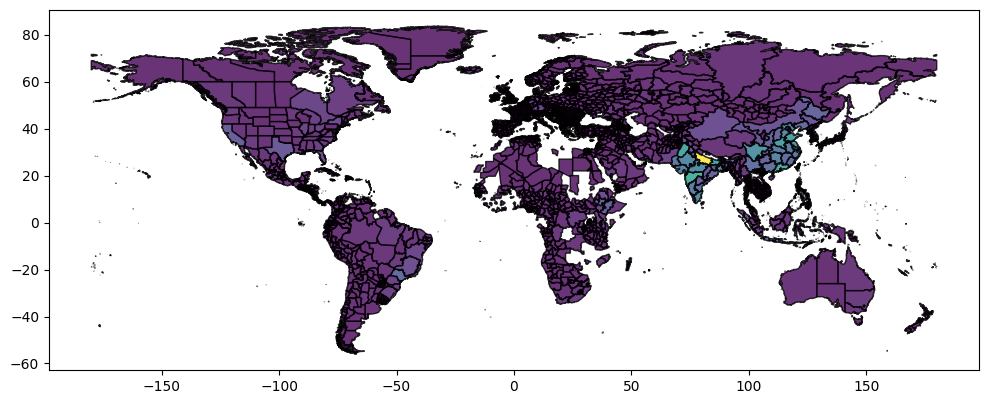

In [422]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

subAreasCountriesMap.plot(
    column='population', 
    cmap='viridis',  # Paleta de colores
    legend=False,    # Desactivamos la leyenda predeterminada para personalizarla
    edgecolor='black', 
    alpha=0.8, 
    ax=ax
)


In [423]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.colorbar as cbar
import matplotlib as mpl

In [424]:
norm = Normalize(vmin=subAreasCountriesMap['population'].min(), 
                 vmax=subAreasCountriesMap['population'].max())


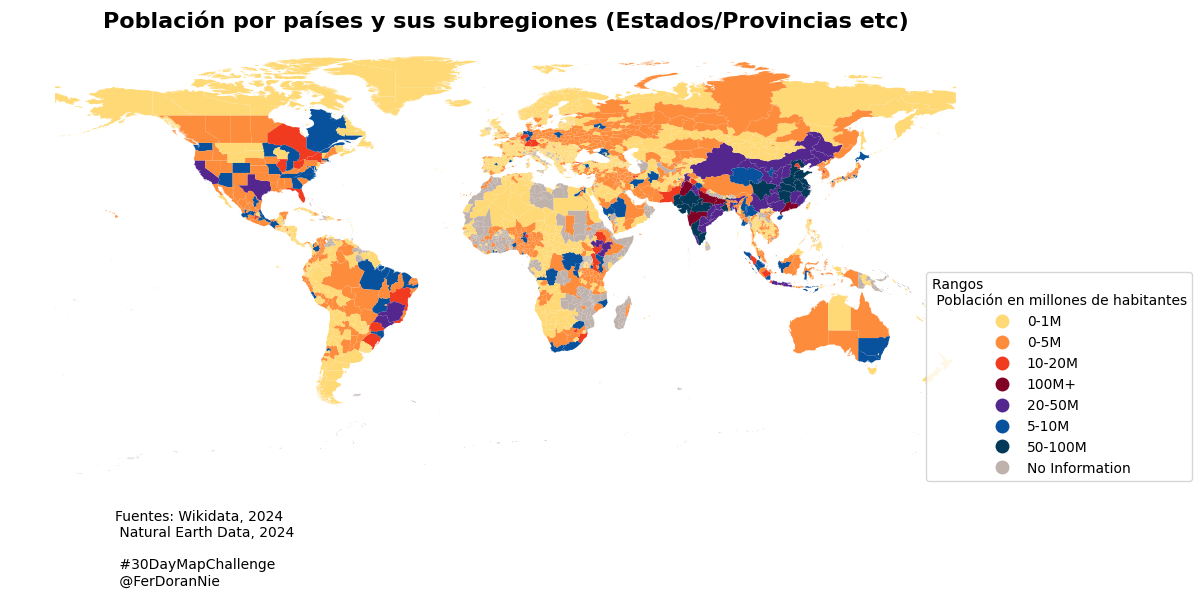

In [425]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

subAreasCountriesMap.plot(
    column='population_category',
    cmap=mpl.colors.ListedColormap(colors2),  # Usar la paleta personalizada
    legend=True,  # Mostrar leyenda
    edgecolor=None,
    linewidth=0.5,
    ax=ax
)

# Personalizar título, subtítulo y leyenda
ax.set_title("Población por países y sus subregiones (Estados/Provincias etc)", fontsize=16, weight='bold')
#ax.set_su
#fig.suptitle("Clasificación de Migración en Rangos de 5 en 5", fontsize=12)
ax.set_axis_off()

# Personalizar leyenda
legend = ax.get_legend()
legend.set_title("Rangos  \n Población en millones de habitantes")
legend.set_bbox_to_anchor((1.2, 0.5))  # Mover la leyenda fuera del mapa
fig.text(0.1, 0.1, "Fuentes: Wikidata, 2024 \n Natural Earth Data, 2024  \n   \n #30DayMapChallenge \n @FerDoranNie", fontsize=10, ha='left')


output_path = "../images/world_population_per_countries_and_their_regions.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')
# Mostrar el mapa
plt.tight_layout()
plt.show()

In [440]:
continents = subAreasCountriesMap['continent_desired'].unique()


In [441]:
continents = [x for x in continents if str(x) != 'nan']
continents

['South America and Central America',
 'Asia',
 'Europe',
 'Africa',
 'North America & Caribbean',
 'Oceania']

South America and Central America


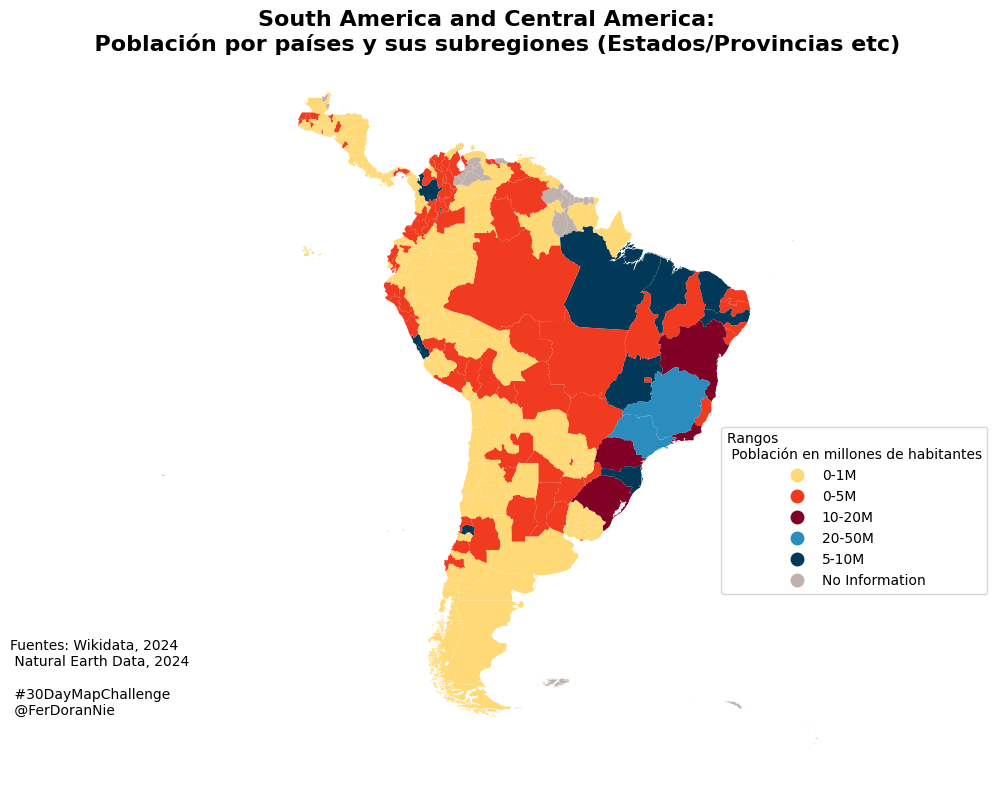

Asia


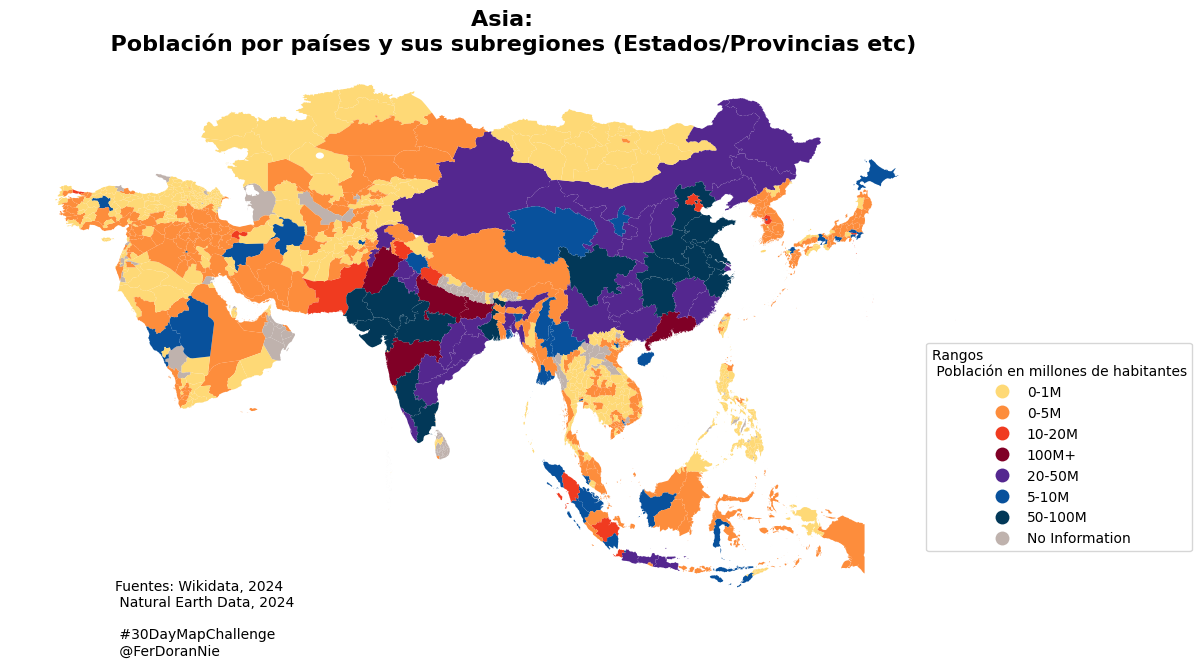

Europe


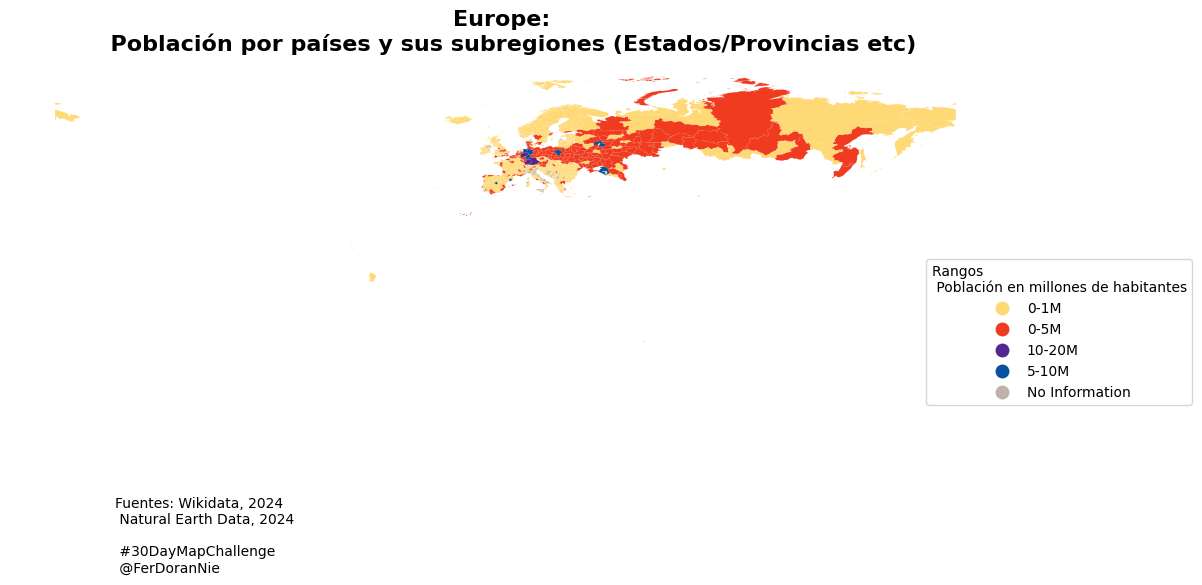

Africa


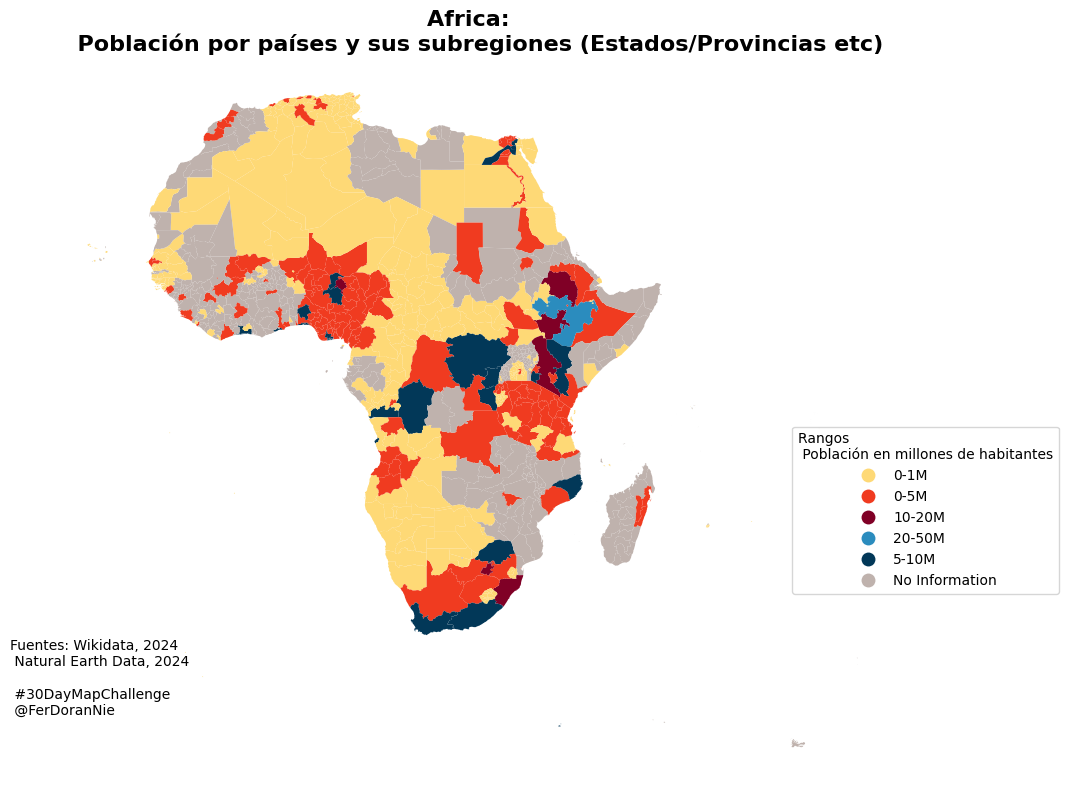

North America & Caribbean


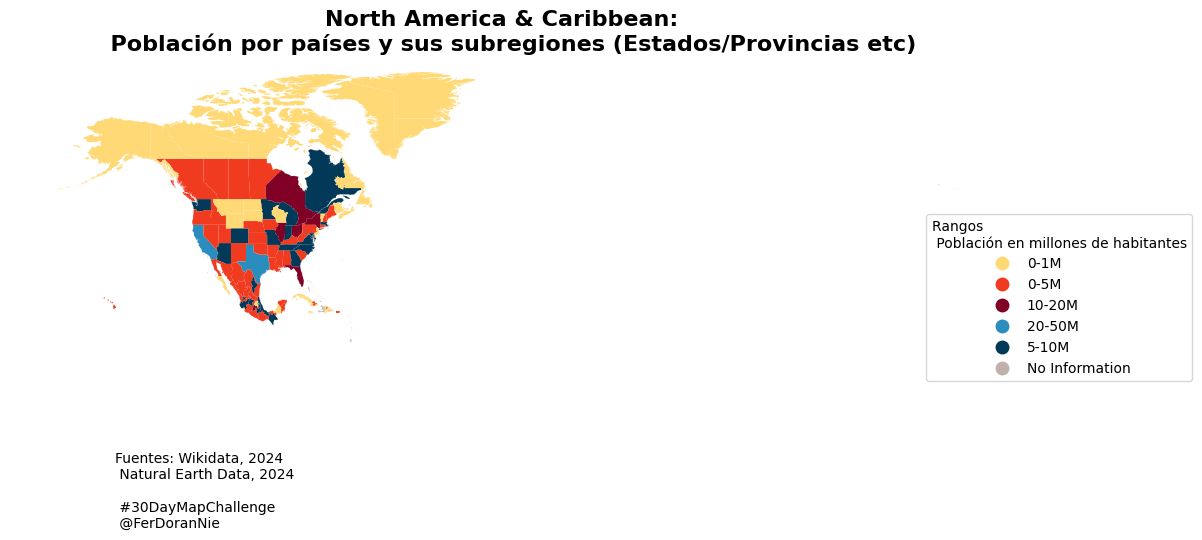

Oceania


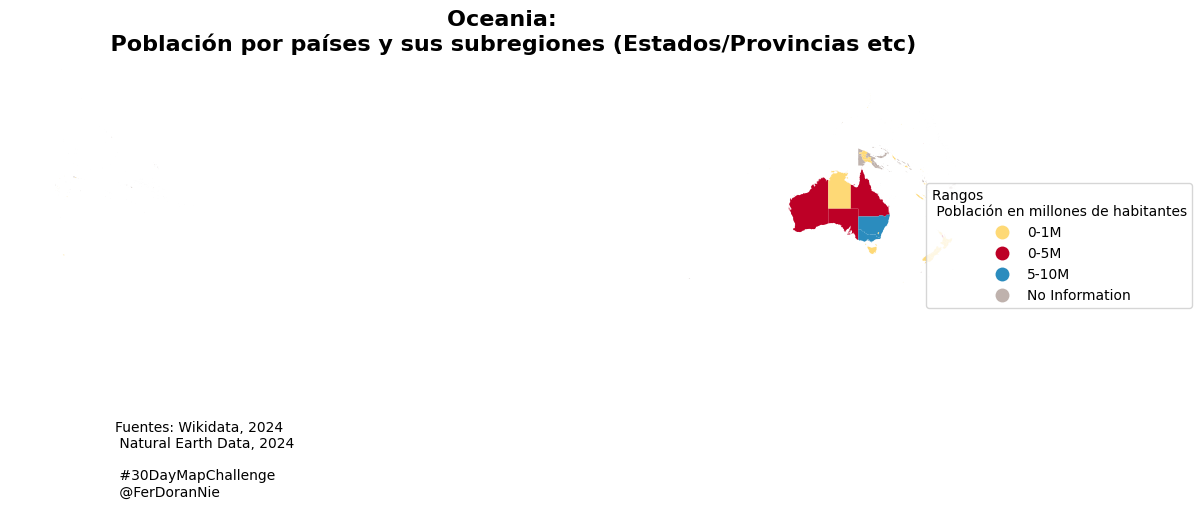

In [444]:
#continents = subAreasCountriesMap['continent_desired'].unique()

for continent in continents:
    print(continent)
    continentLabel = str(continent).replace(' ', '_')
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    continentData = subAreasCountriesMap[subAreasCountriesMap['continent_desired']==continent]
    continentData.plot(
        column='population_category',
        cmap=mpl.colors.ListedColormap(colors2),  # Usar la paleta personalizada
        legend=True,  # Mostrar leyenda
        edgecolor=None,
        linewidth=0.5,
        ax=ax
    )

    # Personalizar título, subtítulo y leyenda
    ax.set_title(f'{continent}: \n  Población por países y sus subregiones (Estados/Provincias etc)', fontsize=16, weight='bold')
    #ax.set_su
    #fig.suptitle("Clasificación de Migración en Rangos de 5 en 5", fontsize=12)
    ax.set_axis_off()

    # Personalizar leyenda
    legend = ax.get_legend()
    legend.set_title("Rangos  \n Población en millones de habitantes")
    legend.set_bbox_to_anchor((1.2, 0.5))  # Mover la leyenda fuera del mapa
    fig.text(0.1, 0.1, "Fuentes: Wikidata, 2024 \n Natural Earth Data, 2024  \n   \n #30DayMapChallenge \n @FerDoranNie", fontsize=10, ha='left')

    plotName = f'../images/{continentLabel}_population_per_countries_and_their_regions.png'
    output_path = plotName
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    # Mostrar el mapa
    plt.tight_layout()
    plt.show()    